In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [ ]:
#upload data to your google drive and then import it
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab Notebooks/Surrogate Model AFPM

/content/drive/MyDrive/Colab Notebooks/Surrogate Model AFPM


In [ ]:
df=pd.read_excel('Data.xlsx')

In [ ]:
df.drop(['Column1','Column2','Column3','Column4'],inplace=True,axis=1) #Drop torque outputs on stator and keep torque values on rotor only

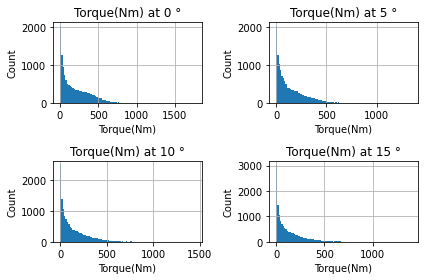

In [ ]:
#Plot distribution of ouput values to be predicted 
tq_fig=df[['Column5','Column6','Column7','Column8']].hist(bins=100)
tq_fig[0,0].set_title('Torque(Nm) at 0 ' + u'\N{DEGREE SIGN}')
tq_fig[0,0].set_xlabel('Torque(Nm)')
tq_fig[0,0].set_ylabel('Count')

tq_fig[0,1].set_title('Torque(Nm) at 5 ' + u'\N{DEGREE SIGN}')
tq_fig[0,1].set_xlabel('Torque(Nm)')
tq_fig[0,1].set_ylabel('Count')

tq_fig[1,0].set_title('Torque(Nm) at 10 ' + u'\N{DEGREE SIGN}')
tq_fig[1,0].set_xlabel('Torque(Nm)')
tq_fig[1,0].set_ylabel('Count')

tq_fig[1,1].set_title('Torque(Nm) at 15 ' + u'\N{DEGREE SIGN}')
tq_fig[1,1].set_xlabel('Torque(Nm)')
tq_fig[1,1].set_ylabel('Count')
plt.tight_layout()
plt.savefig('dist_outputs',dpi=400)

In [ ]:
print(df.sample(10).to_latex()) #for thesis writing purposes

\begin{tabular}{lrlrrrrrr}
\toprule
{} &  AIR GAP(mm) &                  PM MATERIAL &  PM THICKNESS(mm) &  PM ANGLE(degree) &     Column5 &     Column6 &     Column7 &     Column8 \\
\midrule
11731 &          0.5 &                   Ceramic 8A &               8.0 &              30.0 &  130.793988 &   96.143799 &   89.914036 &   83.023094 \\
3547  &          6.0 &                   Ceramic 8A &               9.5 &              30.0 &   47.637906 &   39.496468 &   36.530242 &   31.625646 \\
11607 &          0.5 &             AL9N: Alnico-9NB &               7.5 &              10.0 &  250.344765 &  135.100493 &  101.634581 &   66.259158 \\
8012  &          2.0 &                   Ceramic 8A &               2.5 &              25.0 &   21.830480 &   16.895418 &   14.473011 &    9.354647 \\
6896  &          3.0 &                   Ceramic 8A &               4.0 &              45.0 &   58.241465 &   40.030350 &   37.487143 &   36.201677 \\
5519  &          4.0 &  Neodymium Iron Boron: 32/31 

In [ ]:
material = pd.get_dummies(df['PM MATERIAL'],drop_first=True) #make dummy variables for text values of material

In [ ]:
print(material.sample(10).to_latex()) #for thesis writing purposes

\begin{tabular}{lrrr}
\toprule
{} &  Ceramic 8A &  Neodymium Iron Boron: 32/31 &  Samarium Cobalt: 26/10 \\
\midrule
12226 &           0 &                            0 &                       0 \\
7430  &           1 &                            0 &                       0 \\
10763 &           0 &                            0 &                       1 \\
1867  &           0 &                            0 &                       0 \\
5254  &           1 &                            0 &                       0 \\
7400  &           1 &                            0 &                       0 \\
12003 &           0 &                            1 &                       0 \\
558   &           0 &                            1 &                       0 \\
6004  &           0 &                            1 &                       0 \\
14139 &           0 &                            0 &                       1 \\
\bottomrule
\end{tabular}



In [ ]:
df=pd.concat([df,material],axis=1) #concatenate dummy variables back to table

In [ ]:
df.drop('PM MATERIAL',inplace=True,axis=1) #drop original material column

In [ ]:
df

,AIR GAP(mm),PM THICKNESS(mm),PM ANGLE(degree),Column5,Column6,Column7,Column8,Ceramic 8A,Neodymium Iron Boron: 32/31,Samarium Cobalt: 26/10
0,10.0,10.0,45.0,256.186983,185.251201,175.821860,174.369188,0,1,0
1,10.0,10.0,40.0,245.922283,177.225402,169.921967,165.089137,0,1,0
2,10.0,10.0,35.0,226.632749,165.435742,160.909018,155.031364,0,1,0
3,10.0,10.0,30.0,210.761507,157.238759,147.947251,138.542012,0,1,0
4,10.0,10.0,25.0,190.430890,138.810302,132.007566,113.409976,0,1,0
...,...,...,...,...,...,...,...,...,...,...
14139,0.1,2.0,30.0,539.982217,374.563195,380.660703,426.891224,0,0,1
14140,0.1,2.0,25.0,517.422528,350.200575,401.901944,447.117508,0,0,1
14141,0.1,2.0,20.0,491.769405,369.300098,397.385491,309.000583,0,0,1
14142,0.1,2.0,15.0,495.890451,384.820252,286.383277,258.952629,0,0,1


REMOVE LOW TORQUE VALUES

In [ ]:
df[df['Column5']>50]

,AIR GAP(mm),PM THICKNESS(mm),PM ANGLE(degree),Column5,Column6,Column7,Column8,Ceramic 8A,Neodymium Iron Boron: 32/31,Samarium Cobalt: 26/10
0,10.0,10.0,45.0,256.186983,185.251201,175.821860,174.369188,0,1,0
1,10.0,10.0,40.0,245.922283,177.225402,169.921967,165.089137,0,1,0
2,10.0,10.0,35.0,226.632749,165.435742,160.909018,155.031364,0,1,0
3,10.0,10.0,30.0,210.761507,157.238759,147.947251,138.542012,0,1,0
4,10.0,10.0,25.0,190.430890,138.810302,132.007566,113.409976,0,1,0
...,...,...,...,...,...,...,...,...,...,...
14139,0.1,2.0,30.0,539.982217,374.563195,380.660703,426.891224,0,0,1
14140,0.1,2.0,25.0,517.422528,350.200575,401.901944,447.117508,0,0,1
14141,0.1,2.0,20.0,491.769405,369.300098,397.385491,309.000583,0,0,1
14142,0.1,2.0,15.0,495.890451,384.820252,286.383277,258.952629,0,0,1


In [ ]:
X = df[df['Column5']>50].drop(['Column5','Column6','Column7','Column8'],axis=1)
Y = df[df['Column5']>50][['Column5','Column6','Column7','Column8']]

TRAIN TEST SPLIT

In [ ]:
X = df.drop(['Column5','Column6','Column7','Column8'],axis=1)
Y = df[['Column5','Column6','Column7','Column8']]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_rest, y_train, y_rest = train_test_split(X,Y,test_size=0.5)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_rest,y_rest,test_size=0.5)

SCALING

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X_train= scaler.fit_transform(X_train)

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
X_val = scaler.transform(X_val)

In [ ]:
X_train.shape

(5051, 6)

In [ ]:
X_test.shape

(2526, 6)

In [ ]:
X_train

array([[0.29292929, 0.8125    , 0.42857143, 0.        , 0.        ,
        0.        ],
       [0.29292929, 1.        , 0.57142857, 0.        , 0.        ,
        0.        ],
       [0.24242424, 0.3125    , 0.        , 0.        , 1.        ,
        0.        ],
       ...,
       [0.7979798 , 0.5625    , 0.14285714, 0.        , 0.        ,
        1.        ],
       [0.04040404, 1.        , 0.42857143, 1.        , 0.        ,
        0.        ],
       [0.04040404, 0.875     , 0.42857143, 0.        , 1.        ,
        0.        ]])

Creating a Model

In [ ]:
import time #for measuring computation time

In [ ]:
#define architecture of network
model = Sequential()

model.add(Dense(6,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(4))

model.compile(optimizer='adam',loss='mse')

Training the Model

In [ ]:
start=time.time()
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_val,y_val.values),
          batch_size=128,epochs=400)
end = time.time()

Epoch 1/400
40/40 [==============================] - 1s 6ms/step - loss: 74082.3281 - val_loss: 76477.3359
Epoch 2/400
40/40 [==============================] - 0s 3ms/step - loss: 74004.3203 - val_loss: 76376.7812
Epoch 3/400
40/40 [==============================] - 0s 5ms/step - loss: 73865.3672 - val_loss: 76175.5625
Epoch 4/400
40/40 [==============================] - 0s 4ms/step - loss: 73606.3594 - val_loss: 75845.2188
Epoch 5/400
40/40 [==============================] - 0s 4ms/step - loss: 73193.4609 - val_loss: 75322.2578
Epoch 6/400
40/40 [==============================] - 0s 4ms/step - loss: 72549.4297 - val_loss: 74512.1484
Epoch 7/400
40/40 [==============================] - 0s 4ms/step - loss: 71558.9844 - val_loss: 73294.0391
Epoch 8/400
40/40 [==============================] - 0s 4ms/step - loss: 70142.4453 - val_loss: 71637.5859
Epoch 9/400
40/40 [==============================] - 0s 4ms/step - loss: 68275.9062 - val_loss: 69520.0703
Epoch 10/400
40/40 [=================

In [ ]:
elapsed_time = end - start
print('Execution time:', elapsed_time, 'seconds')

Execution time: 70.54219841957092 seconds


In [ ]:
losses = pd.DataFrame(model.history.history)

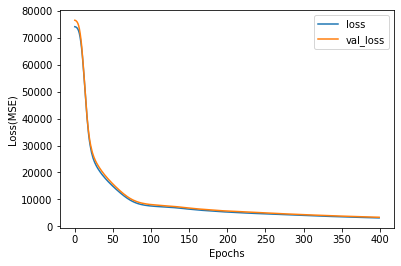

In [ ]:
losses.plot()

plt.xlabel("Epochs")
plt.ylabel("Loss(MSE)")
plt.savefig('loss.png',dpi=400)

Evaluation on Test Data

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score,mean_absolute_percentage_error,r2_score

In [ ]:
X_test


array([[0.06060606, 0.6875    , 0.42857143, 0.        , 1.        ,
        0.        ],
       [0.49494949, 0.375     , 0.57142857, 0.        , 0.        ,
        1.        ],
       [0.19191919, 0.875     , 0.71428571, 0.        , 0.        ,
        1.        ],
       ...,
       [0.19191919, 1.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.07070707, 0.125     , 0.42857143, 0.        , 0.        ,
        0.        ],
       [0.04040404, 0.125     , 0.        , 0.        , 1.        ,
        0.        ]])

In [ ]:

predictions = model.predict(X_test)


In [ ]:
start_pred=time.time()
pred_one = model.predict(np.reshape(X_test[1,:],(1,6)))
end_pred=time.time()
print(end_pred-start_pred)

0.04430246353149414


In [ ]:
r2_score(y_test,predictions)

0.8867080396859484

In [ ]:
mean_absolute_percentage_error(y_test,predictions)

0.30103108567423165

In [ ]:
mean_absolute_error(y_test,predictions)

38.92803760186043

In [ ]:
np.sqrt(mean_squared_error(y_test,predictions))

55.57524445332894

In [ ]:
#make dataframe of all the error metric data
metrics_data = {'r\u00b2 score':[r2_score(y_test['Column5'],predictions[:,0]),
                                   r2_score(y_test['Column6'],predictions[:,1]),
                                   r2_score(y_test['Column7'],predictions[:,2]),
                                   r2_score(y_test['Column8'],predictions[:,3])],
                "MAPE":[mean_absolute_percentage_error(y_test['Column5'],predictions[:,0]),
                        mean_absolute_percentage_error(y_test['Column6'],predictions[:,1]),
                        mean_absolute_percentage_error(y_test['Column7'],predictions[:,2]),
                        mean_absolute_percentage_error(y_test['Column8'],predictions[:,3])],
                "MAE":[mean_absolute_error(y_test['Column5'],predictions[:,0]),
                       mean_absolute_error(y_test['Column6'],predictions[:,1]),
                       mean_absolute_error(y_test['Column7'],predictions[:,2]),
                       mean_absolute_error(y_test['Column8'],predictions[:,3])],
                "RMSE":[np.sqrt(mean_squared_error(y_test['Column5'],predictions[:,0])),
                         np.sqrt(mean_squared_error(y_test['Column6'],predictions[:,1])),
                         np.sqrt(mean_squared_error(y_test['Column7'],predictions[:,2])),
                         np.sqrt(mean_squared_error(y_test['Column8'],predictions[:,3]))]
                                            
                                            
                }
metrics = pd.DataFrame(metrics_data, index=['Torque(Nm) at 0 ' + u'\N{DEGREE SIGN}','Torque(Nm) at 5 ' + u'\N{DEGREE SIGN}','Torque(Nm) at 10 ' + u'\N{DEGREE SIGN}','Torque(Nm) at 15 ' + u'\N{DEGREE SIGN}'])


In [ ]:
print(metrics.to_latex()) #for thesis writing purposes

\begin{tabular}{lrrrr}
\toprule
{} &  r² score &      MAPE &        MAE &       RMSE \\
\midrule
Torque(Nm) at 0 °  &  0.894807 &  0.213017 &  44.180711 &  63.345560 \\
Torque(Nm) at 5 °  &  0.890807 &  0.268578 &  36.365526 &  51.844716 \\
Torque(Nm) at 10 ° &  0.887601 &  0.309928 &  37.031849 &  51.440558 \\
Torque(Nm) at 15 ° &  0.873618 &  0.412601 &  38.134065 &  54.843100 \\
\bottomrule
\end{tabular}



In [ ]:
errors = y_test.values.reshape(2526, 4) - predictions
perc_errors= (abs(y_test.values.reshape(2526, 4) - predictions))/y_test.values.reshape(2526, 4)

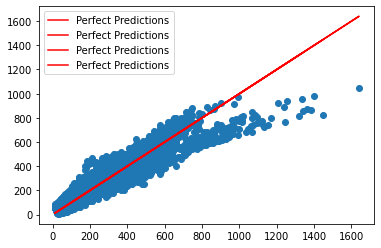

In [ ]:
# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r',label='Perfect Predictions')
plt.legend()

In [ ]:
perc_errors.shape

(2526, 4)

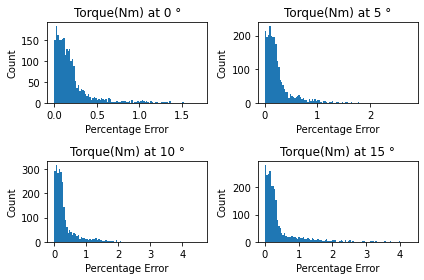

In [ ]:
#plot distribution of percentage errors 
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].hist(perc_errors[:,0],bins=100)
axes[0,0].set_xlabel('Percentage Error')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Torque(Nm) at 0 ' + u'\N{DEGREE SIGN}' )

axes[0,1].hist(perc_errors[:,1],bins=100)
axes[0,1].set_xlabel('Percentage Error')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Torque(Nm) at 5 ' + u'\N{DEGREE SIGN}' )


axes[1,0].hist(perc_errors[:,2],bins=100)
axes[1,0].set_xlabel('Percentage Error')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Torque(Nm) at 10 ' + u'\N{DEGREE SIGN}' )


axes[1,1].hist(perc_errors[:,3],bins=100)
axes[1,1].set_xlabel('Percentage Error')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Torque(Nm) at 15 ' + u'\N{DEGREE SIGN}' )




plt.tight_layout()
plt.savefig('perc_error_dist',dpi=400)

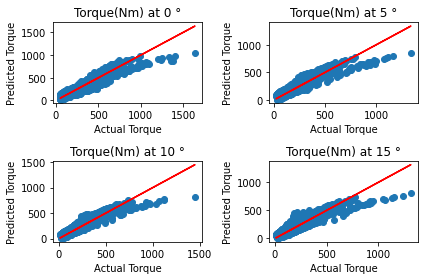

In [ ]:
#plot predictions vs true values
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].scatter(y_test['Column5'],predictions[:,0])
axes[0,0].set_xlabel('Actual Torque')
axes[0,0].set_ylabel('Predicted Torque')
axes[0,0].set_title('Torque(Nm) at 0 ' + u'\N{DEGREE SIGN}' )
axes[0,0].plot(y_test['Column5'],y_test['Column5'],'r',label='Perfect Predictions')

axes[0,1].scatter(y_test['Column6'],predictions[:,1])
axes[0,1].set_xlabel('Actual Torque')
axes[0,1].set_ylabel('Predicted Torque')
axes[0,1].set_title('Torque(Nm) at 5 ' + u'\N{DEGREE SIGN}' )
axes[0,1].plot(y_test['Column6'],y_test['Column6'],'r',label='Perfect Predictions')

axes[1,0].scatter(y_test['Column7'],predictions[:,2])
axes[1,0].set_xlabel('Actual Torque')
axes[1,0].set_ylabel('Predicted Torque')
axes[1,0].set_title('Torque(Nm) at 10 ' + u'\N{DEGREE SIGN}' )
axes[1,0].plot(y_test['Column7'],y_test['Column7'],'r',label='Perfect Predictions')

axes[1,1].scatter(y_test['Column8'],predictions[:,3])
axes[1,1].set_xlabel('Actual Torque')
axes[1,1].set_ylabel('Predicted Torque')
axes[1,1].set_title('Torque(Nm) at 15 ' + u'\N{DEGREE SIGN}' )
axes[1,1].plot(y_test['Column8'],y_test['Column8'],'r',label='Perfect Predictions')



plt.tight_layout()
plt.savefig('scatter',dpi=400)
